# Script to create python and matlab comparison

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cmcrameri.cm as cm


In [2]:
### Latex font in plots
plt.rcParams['font.serif'] = "cmr10"
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.size'] = 24

plt.rcParams['legend.fontsize'] = 24
plt.rcParams['legend.loc'] = 'upper right'
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams["axes.grid"] = False
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['axes.linewidth'] = 2   # Default for all spines
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
# plt.rcParams['text.usetex'] = True
plt.rcParams['xtick.major.size'] = 6  # Thicker major x-ticks
plt.rcParams['xtick.major.width'] = 2  # Thicker major x-
plt.rcParams['ytick.major.size'] = 6  
plt.rcParams['ytick.major.width'] = 2 
plt.rc('axes', unicode_minus=False)


### 1. Helper functions to load in data & compute statisitics

In [3]:
def load_data(step_size, variable_names, var_type, date, solver_type, n_days, order):
    '''
    Loads in the data from the matlab and python simulations.
    The states from the python simulation are stored together with the controls.
    The states from the matlab simulation are stored in seperate csv file.
    '''
    matlab_variables = pd.read_csv(f"../data/model-comparison/matlab/{step_size}StepSize{var_type}{date}{n_days}{solver_type}.csv", sep=",", header=None)[:]
    python_variables = pd.read_csv(f"../data/model-comparison/python/{step_size}StepSizeResults{date}{n_days}{solver_type}{order}.csv", sep=",")[:]
    matlab_variables.columns = variable_names
    return matlab_variables, python_variables

def rRMSE(predictions: np.ndarray | float, truth: np.ndarray | float) -> np.ndarray | float:
    '''
    Function to compute the relate root mean square error (rRMSE).
    Between predictions and true values.
    Arguments:
        predictions: (np.ndarray | float) of  predictions
        truth: (np.ndarray | float) of true values
    Returns:
        rRMSE: (np.ndarray | float)
    '''
    return np.sqrt(sum((truth-predictions)**2)/truth.shape[0])/abs(truth.mean())*100

def RMSE(predictions, truth):
    '''
    Function to compute the root mean square error.
    '''
    return np.sqrt(sum((truth-predictions)**2)/truth.shape[0])

def confidence_interval(data, confidence=1.96):
    '''
    Function to compute the confidence interval of the data.
    '''
    n = data.shape[0]
    m, se = np.mean(data, axis=0), np.std(data, axis=0)
    h = se * confidence / np.sqrt(n)
    return h


### 2. Variables names

In [4]:
step_sizes = ["0.5s", "1.0s", "2.0s"] 

solver_type = "Ode15s"
n_days = "10"
var_type = "States"
order = "4th"
dates = [f"2000{str(month).zfill(2)}01" for month in range(1, 13)]
# state_names = ["co2Air", "co2Top", "tAir", "tTop", "tCan", "tCovIn", "tCovE", "tThScr", \
#         "tFlr", "tPipe", "tSo1", "tSo2", "tSo3", "tSo4", "tSo5", "vpAir", "vpTop", "tLamp", \
#         "tIntLamp", "tGroPipe", "tBlScr", "tCan24", "cBuf", "cLeaf", "cStem", "cFruit", "tCanSum", "Time"]
# weather_names = ["Global radiation", "Outdoor temperature", "Outdoor VP", "Outdoor CO2 concentration", "Outdoor wind speed", "Sky temperature", "Soil temperature", "Daily radiation sum", "Daytime", "Daytime smoothed"]
# control_names = ["uBoil", "uCO2", "uThScr", "uVent", "uLamp", "uIntLamp", "uGroPipe", "uBlScr"]


In [5]:
step_sizes = ["0.01s", "0.1s", "1.0s"]

solver_type = "Ode15s"
n_days = "1"
var_type = "States"
order = "4th"
dates = [f"2000{str(month).zfill(2)}01" for month in range(1, 2)]
dates


['20000101']

In [6]:
state_names = ["co2Air", "co2Top", "tAir", "tTop", "tCan", "tCovIn", "tCovE", "tThScr", \
        "tFlr", "tPipe", "tSo1", "tSo2", "tSo3", "tSo4", "tSo5", "vpAir", "vpTop", "tLamp", \
        "tIntLamp", "tGroPipe", "tBlScr", "tCan24", "cBuf", "cLeaf", "cStem", "cFruit", "tCanSum", "Time"]
weather_names = ["Global radiation", "Outdoor temperature", "Outdoor VP", "Outdoor CO2 concentration", "Outdoor wind speed", "Sky temperature", "Soil temperature", "Daily radiation sum", "Daytime", "Daytime smoothed"]
control_names = ["uBoil", "uCO2", "uThScr", "uVent", "uLamp", "uIntLamp", "uGroPipe", "uBlScr"]


### 3. Load in data and immediately process 

In [7]:

matlab_state_exp = []
python_states_exp = []

for date in dates:
    matlab_states = []
    python_states = []

    for step_size in step_sizes:
        mat_states, py_variables = load_data(step_size, state_names, var_type, date, solver_type, n_days=n_days, order=order)
        matlab_states.append(mat_states)
        python_states.append(py_variables[state_names])
    matlab_state_exp.append(matlab_states)
    python_states_exp.append(python_states)


In [8]:
for i in range(3): print(matlab_state_exp[0][i].shape)


(8640000, 28)
(864000, 28)
(86400, 28)


In [9]:
import sys

In [10]:
for i in range(3): print(sys.getsizeof(python_states_exp[0][i]))

1935360160
193536160
19353760


In [11]:
rRMSEs_exp = []


for matlab_states, python_states in zip(matlab_state_exp[:], python_states_exp[:]):
    rRMSEs_df = pd.DataFrame()
    rRMSEs = np.zeros(shape=(len(matlab_states), len(state_names)-1))
    for i in range(len(step_sizes)):
        mat_states = matlab_states[i]
        py_states = python_states[i]
        for j, col in enumerate(matlab_states[i].columns[:-1]):
            rRMSEs[i,j] += rRMSE(py_states[col].iloc[:], mat_states[col])
    rRMSEs_exp.append(rRMSEs)


In [12]:
rRMSEs_exp[]

SyntaxError: invalid syntax (125416223.py, line 1)

In [13]:
rRMSEs_exp = np.array(rRMSEs_exp)
mean_rRMSEs = rRMSEs_exp.mean(axis=0)
std_rRMSEs = rRMSEs_exp.std(axis=0)
ci95 = confidence_interval(rRMSEs_exp)


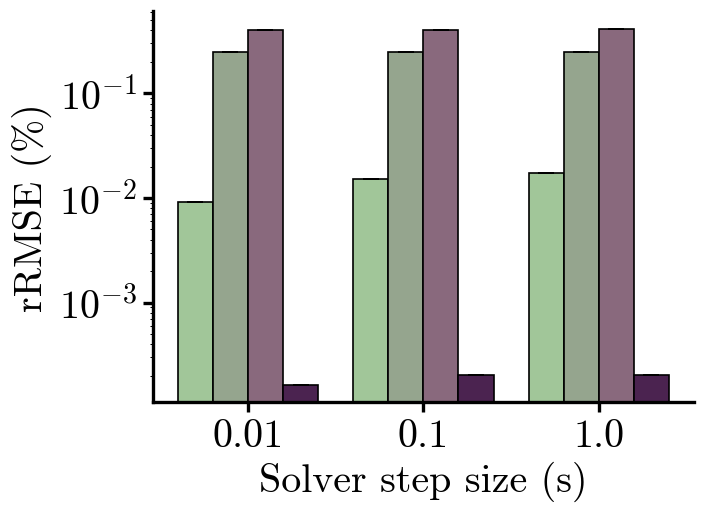

In [14]:
columns_to_plot = ['co2Air', 'tAir', 'vpAir', 'cFruit']
col_names = [r'$\mathregular{CO_2}$', 'Air temperature', 'Air vapour pressure', 'Fruit carbohydrates'] 

step_sizes = ["0.01", "0.1", "1.0"]
# step_sizes = ["0.5", "1.0", "2.0"]

rrmses_df = pd.DataFrame(data=mean_rRMSEs, columns=state_names[:-1])
rrmses_df['Step size'] = step_sizes
rrmses_df_subset = rrmses_df[columns_to_plot]

rrmses_std_df = pd.DataFrame(data=std_rRMSEs, columns=state_names[:-1])
rrmses_std_df['Step size'] = step_sizes
rrmses_std_df_subset = rrmses_std_df[columns_to_plot]

rrmses_ci95_df = pd.DataFrame(data=ci95, columns=state_names[:-1])
rrmses_ci95_df['Step size'] = step_sizes
rrmses_ci95_df_subset = rrmses_ci95_df[columns_to_plot]

# Number of states (or columns) to plot
num_states = len(columns_to_plot)

# Create a figure and axis
fig = plt.figure(dpi=120)
ax = fig.add_subplot()

# Width of a bar 
bar_width = 0.2

# Positions of the bar groups on the x-axis
indices = np.arange(len(rrmses_df_subset))
colors = cm.tokyoS

# Plot each state's data
for i, state in enumerate(columns_to_plot):
    ax.bar(indices + i * bar_width, rrmses_df_subset[state], width=bar_width, label=state, color=colors(i+4), edgecolor='black', alpha=1)

# IF YOU AIM TO PLOT ERROR BARS
for i, state in enumerate(columns_to_plot):
    ax.errorbar(indices + i * bar_width, rrmses_df_subset[state], yerr=rrmses_ci95_df_subset[state], capsize=5, linestyle='None', color='black', fmt='')
# ax.errorbar(index-bar_width, twb_df['CO2'], yerr=twb_errors_df["CO2"], capsize=5, linestyle='None', color='black', fmt='', )

# Set the position of the x ticks
ax.set_xticks(indices + bar_width * (num_states - 1) / 2)

# Set the labels for the x ticks
ax.set_xticklabels(rrmses_df['Step size'])

ax.set_yscale('log')

# Set labels and title
ax.set_xlabel('Solver step size (s)')
ax.set_ylabel('rRMSE (%)')

# Adding the legend and showing the plot
# fig.legend(labels = col_names)
fig.tight_layout()
fig.savefig("rRMSE.svg")
plt.show()


In [17]:
# for state in columns_to_plot:
    # print(state)
print(rrmses_df[columns_to_plot])
    # print(rrmses_ci95_df[state])

     co2Air      tAir     vpAir    cFruit
0  0.009145  0.246223  0.406931  0.000164
1  0.015214  0.247714  0.408031  0.000204
2  0.017194  0.249011  0.411151  0.000201


In [ ]:
rrmses_ci95_df

,co2Air,co2Top,tAir,tTop,tCan,tCovIn,tCovE,tThScr,tFlr,tPipe,...,tIntLamp,tGroPipe,tBlScr,tCan24,cBuf,cLeaf,cStem,cFruit,tCanSum,Step size
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
